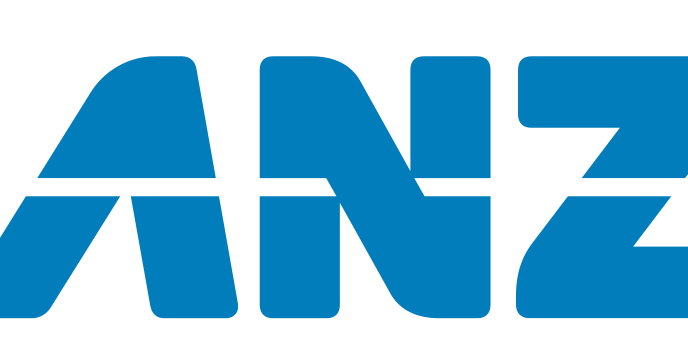

#Task 2

---



#**Predictive Analytics**
Explore correlations between customer attributes, build a regression and a decision-tree prediction model based on your findings.

#Importing the libraries

---



In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode,mean,median

#Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [145]:
#Reading the Excel data
data = pd.read_excel('/content/ANZ synthesised transaction dataset.xlsx')
data.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [146]:
pd.DataFrame({"Columns": data.columns})

,Columns
0,status
1,card_present_flag
2,bpay_biller_code
3,account
4,currency
5,long_lat
6,txn_description
7,merchant_id
8,merchant_code
9,first_name


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

In [148]:
data['txn_description'].unique()

array(['POS', 'SALES-POS', 'PAYMENT', 'INTER BANK', 'PAY/SALARY',
       'PHONE BANK'], dtype=object)

In [149]:
# Check the salary payment frequency of each customer
salary_df = pd.DataFrame({"customer_id": data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [150]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
freq =[]
df_amt=[]

for i in range(len(salary_df)):
  salary = data.loc[(data.customer_id == salary_df.customer_id[i]) & (data.txn_description == "PAY/SALARY"),['date','amount']].groupby('date',as_index = False).sum()
  count = len(salary)
  if count == 0:
    freq.append(np.nan)
    df_amt.append(np.nan)
  else:
      payment_days = []
      for date in range(len(salary)-1):
        payment_days.append((salary.date[date+1]-salary.date[date]).days)
      freq.append(max(payment_days))
      df_amt.append(mode(salary.amount))
  
salary_df['salary_freq'] = freq
salary_df['salary_amount'] = df_amt
salary_df['Annual_salary']= salary_df['salary_amount'] / salary_df['salary_freq'] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,Annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


In [151]:
salary_df.corr()

,salary_freq,salary_amount,Annual_salary
salary_freq,1.000000,0.623567,-0.189054
salary_amount,0.623567,1.000000,0.533460
Annual_salary,-0.189054,0.533460,1.000000


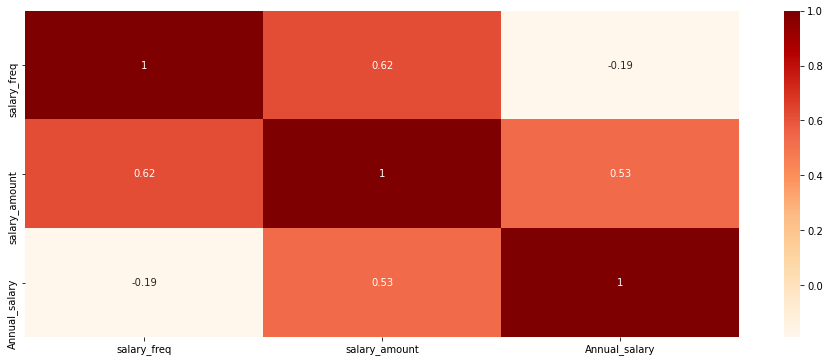

In [152]:
plt.figure(figsize=(16,6))
sns.heatmap(salary_df.corr(),annot=True,cmap='OrRd')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Annual salary')

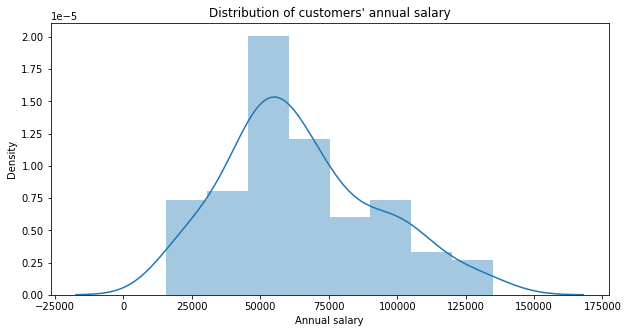

In [153]:
# Plot customer's annual salary distribution 
plt.figure(figsize = (10, 5))
sns.distplot(salary_df.Annual_salary)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual salary")

# Predictor variables

In [154]:
# Unique customer id's 
unique_id = data.customer_id.unique()
len(unique_id)

100

In [155]:
unique_id[:5]

array(['CUS-2487424745', 'CUS-2142601169', 'CUS-1614226872',
       'CUS-2688605418', 'CUS-4123612273'], dtype=object)

In [156]:
avg_weekly_trans = []
for i in unique_id:
    array = data.loc[data.customer_id == i, "date"]
    avg_weekly_trans.append(round(len(array)/array.nunique()*7))
avg_weekly_trans[:5]

[48, 29, 24, 14, 21]

In [157]:
max_amount = []
for i in unique_id:
    array = data.loc[data.customer_id == i, "amount"]
    max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

In [158]:
no_large_trans = []
for i in unique_id:
    count = 0
    array = data.loc[data.customer_id == i, "amount"]
    for amount in array:
        if amount >100:
            count += 1
    no_large_trans.append(count)
no_large_trans[:5]

[22, 23, 22, 25, 32]

In [159]:
no_of_days_with_tans = []
for i in unique_id:
  array = data.loc[data.customer_id == i,'date']
  no_of_days_with_tans.append(array.nunique())
no_of_days_with_tans[:5]

[85, 74, 76, 63, 44]

In [160]:
avg_trans_amt = []
for i in unique_id:
  array = data.loc[data.customer_id == i,'amount']
  avg_trans_amt.append(array.mean())
avg_trans_amt[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

In [161]:
median_balance = []
for i in unique_id:
    array = data.loc[data.customer_id == i, "balance"]
    median_balance.append(array.median())
median_balance[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

In [162]:
state = []
for i in unique_id:
  array = data.loc[data.customer_id == i,"merchant_state"]
  state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

In [163]:
age = []
for i in unique_id:
    array = data.loc[data.customer_id == i, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [164]:
gender = []
for i in unique_id:
    array = data.loc[data.customer_id == i, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

In [165]:
# Predictor variables 
features_df = pd.DataFrame({"customer_id": unique_id, 
                            "avg_no_weekly_trans": avg_weekly_trans, 
                            "max_amount": max_amount, 
                            "no_large_trans": no_large_trans,
                            "avg_trans_amount": avg_trans_amt,
                            "median_balance": median_balance, 
                            "state": state,
                            "age": age,
                            "gender": gender})
features_df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F


In [166]:
# Concat annual salary column to features dataframe  
df = pd.concat([features_df, salary_df.Annual_salary], axis = 1)
df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,Annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F,55728.801429


In [167]:
df.replace({'M':1},inplace=True)
df.replace({'F':0},inplace=True)

In [168]:
df.head(100)

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,Annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,0,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,1,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,0,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,1,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,0,55728.801429
...,...,...,...,...,...,...,...,...,...,...
95,CUS-2505971401,14,1946.57,22,291.293333,11410.18,NaN,40,0,101569.241786
96,CUS-2819545904,11,3231.26,27,448.658413,110017.62,NaN,42,1,84301.265357
97,CUS-3395687666,8,1757.81,15,355.400250,16758.60,NaN,42,1,45860.007321
98,CUS-1147642491,15,1711.39,31,245.600169,8473.43,NSW,34,0,89297.885357


In [169]:
df.shape

(100, 10)

In [172]:
df.isnull().sum()

customer_id             0
avg_no_weekly_trans     0
max_amount              0
no_large_trans          0
avg_trans_amount        0
median_balance          0
state                  43
age                     0
gender                  0
Annual_salary           0
dtype: int64

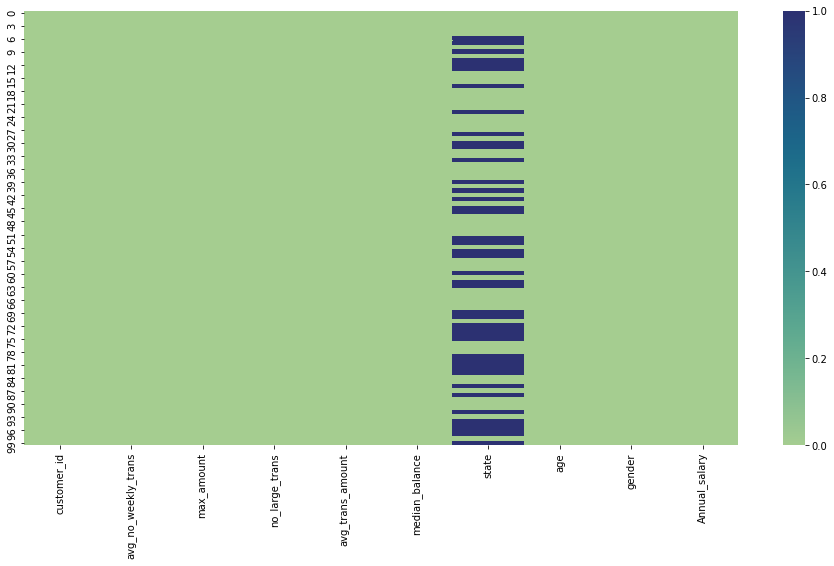

In [170]:
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(),cmap='crest')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


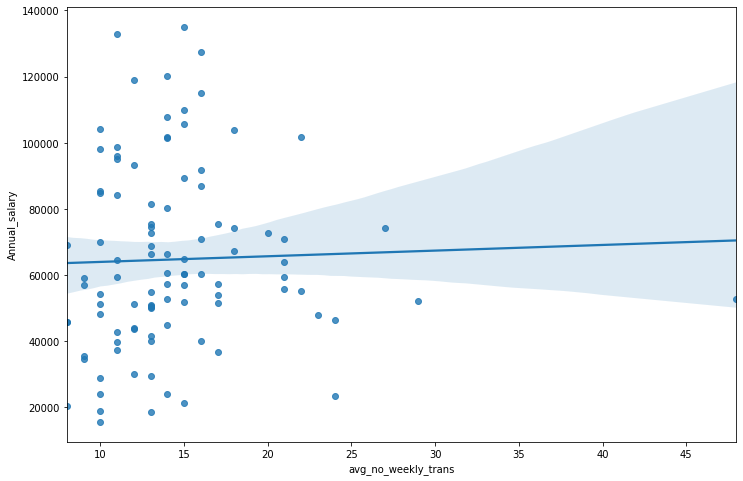

In [174]:
plt.figure(figsize=(12, 8))
sns.regplot("avg_no_weekly_trans", "Annual_salary", fit_reg=True, data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


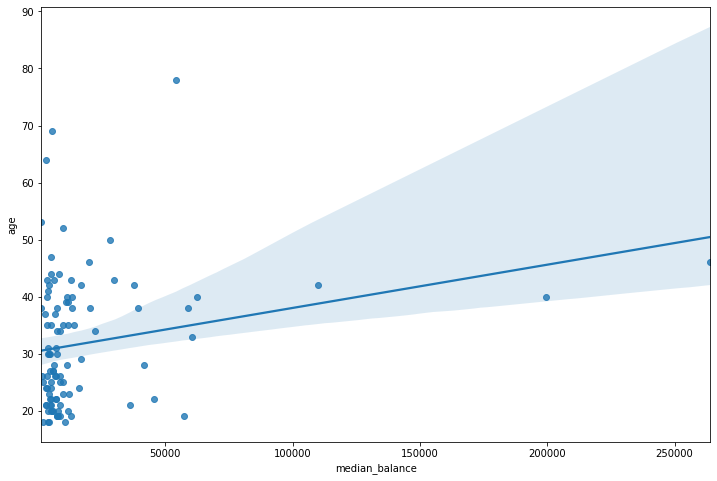

In [177]:
plt.figure(figsize=(12,8))
sns.regplot('median_balance','age',data=df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


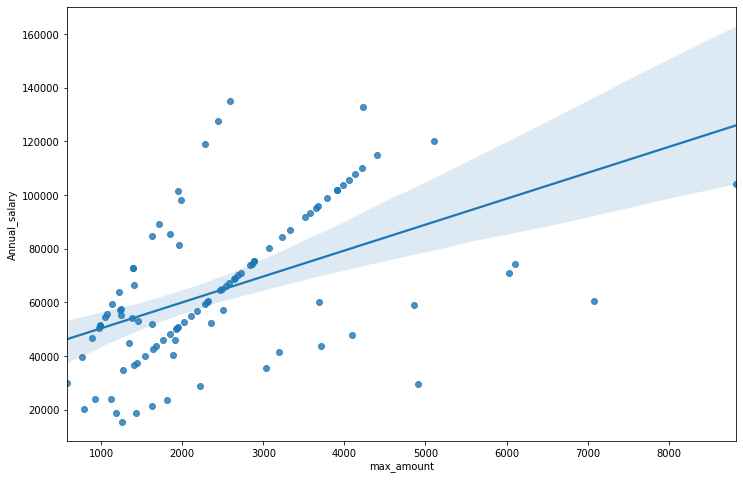

In [179]:
plt.figure(figsize=(12,8))
sns.regplot('max_amount','Annual_salary',fit_reg = True,data=df)

In [180]:
df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,Annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,0,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,1,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,0,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,1,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,0,55728.801429


#Linear Regression Model

---



In [183]:
# X AND Y OF MACHINE LEARNING:-
X = df[['age','median_balance','max_amount','avg_no_weekly_trans','no_large_trans','gender']].values

Y = df.Annual_salary
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (100, 6)
Y shape:  (100,)


In [185]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [186]:
lr = LinearRegression()

In [187]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [190]:

y_pred = lr.predict(X_test)

In [191]:
# RMSE
print("RMSE: ", round(np.sqrt(mean_squared_error(y_pred, y_test))))

RMSE:  23186


In [206]:
print("The model predicts salary will be:")
print(round(lr.predict([[35,2145,1402,7,3,0]])[0]))

The model predicts salary will be:
18533


#Decision Tree:-

In [196]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train , y_train)
tree = dtree.predict(X_test)

In [197]:
# Scores using X and Y values for Decission tree
dtree.score(X_test, y_test)

0.4257447091265718

In [202]:
print("RMSE: ", round(np.sqrt(mean_squared_error(tree, y_test))))
print("coefficient of determination", r2_score(y_test , tree))

RMSE:  19880
coefficient of determination 0.4257447091265718


In [205]:
print("The model predicts salary will be:")
print(round(dtree.predict([[35,2145,1402,7,3,0]]) [0]))

The model predicts salary will be:
18706


#Conclusion

---
The RMSE for both models are over $20,000 and although decision tree performed better than linear regression by having a smaller RMSE, both models still appear to be highly inaccurate. Therefore, it is risky to use them to predict customers' income bracket. More data is required to develop a more reliable model.

Nevertheless, one can invest more time into coming up with more features and selecting the best ones using backward elimination by optimising for a specific metric like AIC, however I doubt the result will be materially different as we only have a very limited amount of data (100 salaries) available.

